# Final Project Metode Optimasi
## Studi Kasus Pupuk Sriwijaya

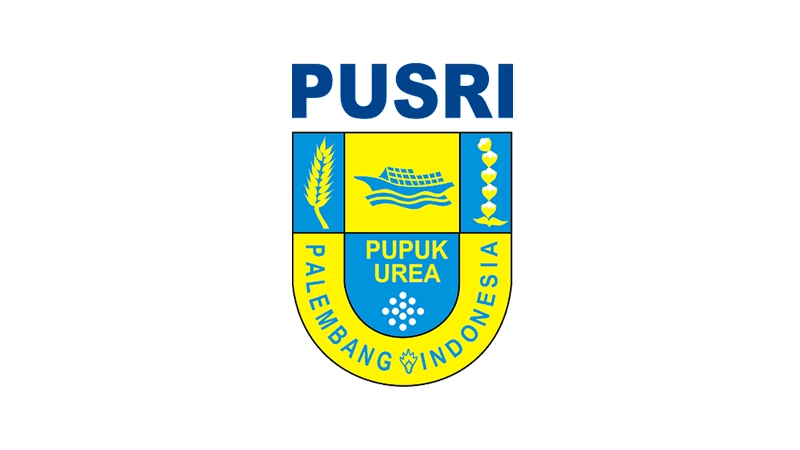

### Anggota Kelompok :     


* Bagus Cipta Pratama (23/516539/PA/22097)
* Ravie Arjun Nadhief (23/522765/PA/22491)
* Nasya Putri Raudhah Dahlan (23/513931/PA/21967)


## Objectives

### Problem Overview
Dataset aktivitas harian (*daily activity*) memuat informasi multidimensi seperti jarak, durasi, kecepatan, dan detak jantung yang polanya sulit dipahami secara manual. Masalah utamanya adalah bagaimana mengelompokkan ribuan data aktivitas ini ke dalam segmen-segmen (cluster) yang bermakna untuk memahami karakteristik pengguna.

Secara matematis, ini adalah masalah optimasi non-linear untuk meminimalkan variansi di dalam setiap kelompok.

### Proposed Solution
Solusi yang diajukan adalah mengimplementasikan algoritma **K-Means Clustering** yang dibangun dari nol (*from scratch*) menggunakan metode optimasi **Gradient Descent**.

Pendekatan ini tidak menggunakan *solver* bawaan library, melainkan secara eksplisit menghitung turunan gradien dari fungsi objektif **Within-Cluster Sum of Squares (WCSS)** untuk memperbarui posisi *centroid* secara iteratif hingga mencapai konvergensi optimal.

## Import Dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from tqdm import tqdm  # Untuk progress bar di loop
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)  # Reproducibility

In [ ]:
!pip install ydata-profiling

## Load Dataset

In [ ]:
df = pd.read_csv('data 1 Daily Activity - viral_jan_jun_2025.csv')

## EDA

In [ ]:
df.head()

distance_meters  moving_time_seconds  elapsed_time_seconds  type  \
0            31260                 2353                  2484  Walk   
1            26900                 1375                  1375  Walk   
2            30200                 1521                  1521  Walk   
3            28500                 1480                  1480  Walk   
4            26300                 1286                  1286  Walk   

  start_date_utc   end_date_utc  average_speed_kmh  max_speed_kmh  \
0  4/12/25 10:33  4/12/25 11:15               1329           2773   
1   1/2/25 18:31   1/2/25 18:54               1956              0   
2   1/3/25 18:54   1/3/25 19:20               1986              0   
3    1/4/25 9:07    1/4/25 9:31               1926              0   
4  1/13/25 18:46  1/13/25 19:07               2045              0   

   average_heartrate_bpm  average_cadence_spm     badge  
0                      0                    0  13289547  
1                   1226                 1022  13267699  
2                   1261                  998  13267699  
3                   1292                  998  13267699  
4                   1345                 1002  13267699

In [ ]:
from ydata_profiling import ProfileReport
# Buat laporan profiling
profile = ProfileReport(df, title="Profiling Report", explorative=True)

# Tampilkan di notebook (jika pakai Jupyter/Colab)
profile.to_notebook_iframe()

# Simpan ke file HTML
profile.to_file("profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df.describe()

distance_meters  moving_time_seconds  elapsed_time_seconds  \
count     2.215900e+04         22159.000000          22159.000000   
mean      4.305905e+04          2431.322442           2572.393384   
std       4.160534e+04          1069.870058           1281.047637   
min       2.500000e+04            70.000000             70.000000   
25%       2.625400e+04          1820.000000           1868.000000   
50%       3.032100e+04          2162.000000           2243.000000   
75%       5.052000e+04          2795.000000           3011.000000   
max       1.667600e+06         28847.000000          45487.000000   

       average_speed_kmh  max_speed_kmh  average_heartrate_bpm  \
count       22159.000000   22159.000000           22159.000000   
mean         1612.443612    1378.142651             533.237556   
std          1034.880575    2301.368147             652.852899   
min             8.000000       0.000000               0.000000   
25%          1222.000000     224.000000               0.000000   
50%          1431.000000     348.000000               0.000000   
75%          2007.500000    2045.000000            1176.000000   
max         73386.000000   43833.000000            1908.000000   

       average_cadence_spm         badge  
count         22159.000000  2.215900e+04  
mean            990.257412  1.352375e+07  
std             604.349426  8.212613e+05  
min               0.000000  1.318629e+07  
25%             944.000000  1.326929e+07  
50%            1120.000000  1.330032e+07  
75%            1386.000000  1.335902e+07  
max            3880.000000  1.670038e+07

In [ ]:
df = df[df['average_heartrate_bpm'] != 0]

## Preprocessing dan Feature Engineering

Tahap ini bertujuan mengubah data mentah menjadi format numerik yang valid untuk perhitungan jarak Euclidean pada algoritma K-Means.

### 1. Ekstraksi Durasi
Mengonversi data waktu (*string*) menjadi objek *datetime* untuk menghitung durasi aktivitas dalam satuan menit:

$$
\text{Duration (min)} = \frac{(\text{End Time} - \text{Start Time})}{60}
$$

### 2. One-Hot Encoding (Kategorikal)
Mengubah kolom kategori `type` (misal: "Run", "Ride") menjadi vektor biner terpisah. Langkah ini mencegah algoritma mengasumsikan adanya urutan nilai/ranking yang salah (*false ordinality*) antar jenis aktivitas.

### 3. Transformasi Fitur Siklis (Waktu)
Fitur waktu (Jam, Hari, Bulan) bersifat siklus; contohnya jam 23:00 sangat dekat dengan 00:00. Representasi angka linear biasa gagal menangkap kedekatan ini.

Solusinya adalah memetakan waktu ke koordinat lingkaran menggunakan Trigonometri agar kontinuitas data terjaga:

$$
t_{\sin} = \sin\left(\frac{2\pi t}{T}\right), \quad t_{\cos} = \cos\left(\frac{2\pi t}{T}\right)
$$

*(Dimana $t$ adalah nilai waktu dan $T$ adalah periode maksimum: 24 untuk jam, 7 untuk hari, 12 untuk bulan).*

## 4. Pembersihan Akhir
Menghapus kolom tanggal asli (`start_date_utc`, `end_date_utc`) karena informasi numerik pentingnya sudah diekstraksi ke dalam fitur-fitur baru di atas.

In [ ]:
# Convert datetime
df['start_date_utc'] = pd.to_datetime(df['start_date_utc'], format="%m/%d/%y %H:%M")
df['end_date_utc']   = pd.to_datetime(df['end_date_utc'], format="%m/%d/%y %H:%M")

# Duration
df['duration_minutes'] = (df['end_date_utc'] - df['start_date_utc']).dt.total_seconds() / 60

# One-hot encoding type (Improvement: Pakai pd.get_dummies, lebih simple)
df = pd.get_dummies(df, columns=['type'], prefix='type', dtype=float)

# Cyclical features
df['start_hour']      = df['start_date_utc'].dt.hour
df['start_dayofweek'] = df['start_date_utc'].dt.dayofweek
df['start_month']     = df['start_date_utc'].dt.month

df['start_hour_sin'] = np.sin(2 * np.pi * df['start_hour']/24)
df['start_hour_cos'] = np.cos(2 * np.pi * df['start_hour']/24)
df['start_dow_sin']  = np.sin(2 * np.pi * df['start_dayofweek']/7)
df['start_dow_cos']  = np.cos(2 * np.pi * df['start_dayofweek']/7)
df['start_month_sin']= np.sin(2 * np.pi * df['start_month']/12)
df['start_month_cos']= np.cos(2 * np.pi * df['start_month']/12)

# Drop datetime columns
df.drop(columns=['start_date_utc', 'end_date_utc'], inplace=True)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer

# Kolom numerik yang mau ditransformasi
cols = [
    "distance_meters",
    "moving_time_seconds",
    "elapsed_time_seconds",
    "average_speed_kmh",
    "max_speed_kmh",
    "average_heartrate_bpm",
]

# Copy biar aman
X = df[cols].copy()

# Bersihkan nilai infinite & NaN
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# Buat transformer Yeo-Johnson
scaler = PowerTransformer(method='yeo-johnson', standardize=True)

# Fit-transform
X_scaled = scaler.fit_transform(X)

# Masukkan kembali ke DataFrame
df_yeojohnson = df.copy()
df_yeojohnson[cols] = X_scaled

df_yeojohnson.head()


distance_meters  moving_time_seconds  elapsed_time_seconds  \
1        -0.995183            -1.197441             -1.235186   
2        -0.587552            -0.910448             -0.955147   
3        -0.785321            -0.987243             -1.029997   
4        -1.080715            -1.392949             -1.426442   
5        -1.264516            -1.609733             -1.638962   

   average_speed_kmh  max_speed_kmh  average_heartrate_bpm  \
1           0.243515      -2.111293              -0.228912   
2           0.272063      -2.111293              -0.089735   
3           0.214808      -2.111293               0.033579   
4           0.327755      -2.111293               0.244494   
5           0.378221      -2.111293              -0.093712   

   average_cadence_spm     badge  duration_minutes  type_Ride  ...  type_Walk  \
1                 1022  13267699              23.0        0.0  ...        1.0   
2                  998  13267699              26.0        0.0  ...        1.0   
3                  998  13267699              24.0        0.0  ...        1.0   
4                 1002  13267699              21.0        0.0  ...        1.0   
5                 1082  13267699              20.0        0.0  ...        1.0   

   start_hour  start_dayofweek  start_month  start_hour_sin  start_hour_cos  \
1          18                3            1       -1.000000   -1.836970e-16   
2          18                4            1       -1.000000   -1.836970e-16   
3           9                5            1        0.707107   -7.071068e-01   
4          18                0            1       -1.000000   -1.836970e-16   
5          17                2            1       -0.965926   -2.588190e-01   

   start_dow_sin  start_dow_cos  start_month_sin  start_month_cos  
1       0.433884      -0.900969              0.5         0.866025  
2      -0.433884      -0.900969              0.5         0.866025  
3      -0.974928      -0.222521              0.5         0.866025  
4       0.000000       1.000000              0.5         0.866025  
5       0.974928      -0.222521              0.5         0.866025  

[5 rows x 23 columns]

In [ ]:
# from sklearn.preprocessing import StandardScaler

# # Ambil kembali fitur yang sudah ditransformasi Yeo-Johnson
# X2 = df_yeojohnson[cols].copy()

# # Standard scaler
# scaler2 = StandardScaler()
# X_scaled_final = scaler2.fit_transform(X2)

# # Masukkan ke DataFrame baru
# df_final = df_yeojohnson.copy()
# df_final[cols] = X_scaled_final

# df_final.head()


## Scaling

## Steepest Descent K-Means

Dalam tugas ini, metode optimasi **Steepest Descent** (Gradient Descent) diterapkan untuk meminimalkan fungsi objektif K-Means. Berbeda dengan algoritma Lloyd standar yang langsung mengambil rata-rata (*mean*), metode ini memperbarui posisi *centroid* secara iteratif berdasarkan arah gradien negatif dari fungsi error.

### 1. Fungsi Tujuan (Objective Function)

Masalah optimasi ini bertujuan untuk meminimalkan **Within-Cluster Sum of Squares (WCSS)**. Fungsi kerugian (*Loss Function*) $J$ didefinisikan sebagai jumlah kuadrat jarak antara setiap titik data $x_i$ dengan *centroid* terdekatnya $\mu_j$.

Dalam kode, fungsi ini diimplementasikan sebagai `compute_wcss`:

$$
J(\mu) = \sum_{j=1}^{k} \sum_{x_i \in C_j} ||x_i - \mu_j||^2
$$

Dimana:
* $k$: Jumlah cluster.
* $C_j$: Himpunan titik data yang termasuk dalam cluster ke-$j$.
* $\mu_j$: Centroid dari cluster ke-$j$.
* $||x_i - \mu_j||^2$: Jarak Euclidean kuadrat.

##3 2. Turunan Gradien (Gradient Computation)

Untuk menggunakan Steepest Descent, kita perlu menghitung gradien fungsi $J$ terhadap setiap centroid $\mu_j$. Gradien menunjukkan arah kenaikan terbesar dari fungsi error, sehingga untuk meminimalkan error, kita harus bergerak ke arah berlawanan (negatif gradien).

Turunan parsial fungsi objektif terhadap $\mu_j$ adalah:

$$
\nabla_{\mu_j} J = \frac{\partial}{\partial \mu_j} \sum_{x_i \in C_j} (x_i - \mu_j)^2
$$

Dengan aturan rantai (*chain rule*), turunannya menjadi:

$$
\nabla_{\mu_j} J = \sum_{x_i \in C_j} 2(\mu_j - x_i)
$$

Persamaan ini dapat disederhanakan menjadi bentuk vektor yang lebih efisien secara komputasi:

$$
\nabla_{\mu_j} J = 2 \left( N_j \mu_j - \sum_{x_i \in C_j} x_i \right)
$$

Di mana $N_j$ adalah jumlah titik data dalam cluster $j$.


### 3. Aturan Pembaruan (Update Rule)

Algoritma Steepest Descent memperbarui posisi *centroid* dengan menggesernya ke arah negatif gradien dikalikan dengan laju pembelajaran (*learning rate* atau $\alpha$).

$$
\mu_j^{(t+1)} = \mu_j^{(t)} - \alpha \cdot \nabla_{\mu_j} J
$$

**Implementasi:**

```python
centroids = centroids - alpha * grads
```

### 4. Alur Algoritma (Algorithm Process)

Proses optimasi berjalan mengikuti langkah-langkah iteratif berikut:

1. **Inisialisasi:**

   * Memilih $k$ titik acak dari dataset sebagai posisi awal centroid.
   * Menetapkan *learning rate* awal ($\alpha = 0.01$).

2. **Cluster Assignment (Langkah Evaluasi):**

   * Menghitung jarak Euclidean setiap titik data ke semua centroid saat ini.
   * Setiap titik $x_i$ ditetapkan ke cluster $j$ yang memiliki jarak terdekat (*argmin*).

3. **Evaluasi Loss & Adaptive Learning Rate:**

   * Hitung nilai total error $J$ (WCSS) saat ini.
   * **Fitur Adaptif:** Jika $J$ meningkat dibandingkan iterasi sebelumnya (indikasi divergensi), maka:
     $$
     \alpha \leftarrow \frac{\alpha}{2}
     $$
     untuk menstabilkan proses optimasi.

4. **Update Centroid:**

   * Hitung gradien $\nabla J$ menggunakan data tiap cluster terbaru.
   * Perbarui posisi centroid dengan rumus Steepest Descent.

5. **Konvergensi:**

   * Berhenti jika perubahan loss sangat kecil (di bawah `tol`) atau jumlah iterasi mencapai `max_iter`.

Pendekatan ini memastikan bahwa algoritma tidak sekadar menghitung rata-rata, melainkan benar-benar melakukan pencarian matematis menuju minimum lokal dari fungsi objektif.

In [ ]:
# -------------------------------
# 4. Implementasi Steepest Descent K-Means (diperbaiki)
# -------------------------------
def compute_wcss(X, centroids, labels):
    return np.sum((X - centroids[labels])**2)

def compute_gradient(X, labels, centroids, k):
    grads = np.zeros_like(centroids)
    for j in range(k):
        cluster_points = X[labels == j]
        if len(cluster_points) > 0:
            grads[j] = 2 * (centroids[j] * len(cluster_points) - np.sum(cluster_points, axis=0))
    return grads

def kmeans_steepest_descent(X, k, alpha=0.01, tol=1e-6, loss_threshold=1e-3, n_init=10):
    best_wcss = np.inf
    best_centroids = None
    best_labels = None
    best_loss_history = None

    for init in range(n_init):
        np.random.seed(init)
        centroids = X[np.random.choice(X.shape[0], k, replace=False)].copy()

        loss_history = []
        prev_loss = np.inf
        it = 0
        alpha_init = alpha

        while True:
            it += 1

            # Step 1: Assign cluster
            distances = np.linalg.norm(X[:, None] - centroids[None, :], axis=2)
            labels = np.argmin(distances, axis=1)

            # Step 2: Hitung WCSS
            loss = compute_wcss(X, centroids, labels)
            loss_history.append(loss)

            # Step 3: Adaptive learning rate
            if loss > prev_loss:
                alpha *= 0.5

            # Konvergensi
            if it > 5:
                delta = abs(prev_loss - loss)
                if loss < loss_threshold and delta < tol:
                    break

            # HARD CAP (anti infinite loop)
            if it > 5000:
                break

            prev_loss = loss

            # Step 4: Update centroid
            grads = compute_gradient(X, labels, centroids, k)
            centroids -= alpha * grads

            # Step 5: Handle empty clusters
            unique = np.unique(labels)
            if len(unique) < k:
                empty = list(set(range(k)) - set(unique))
                for j in empty:
                    centroids[j] = X[np.random.choice(len(X))]

        if loss < best_wcss:
            best_wcss = loss
            best_centroids = centroids
            best_labels = labels
            best_loss_history = loss_history

        alpha = alpha_init  # reset alpha

    return best_centroids, best_labels, best_loss_history, best_wcss


## Elbow Method

Menghitung WCSS & Silhouette Score...


 11%|█         | 1/9 [00:58<07:44, 58.10s/it]

k=2 | WCS=39795.08 | Silhouette=0.2750


 22%|██▏       | 2/9 [02:02<07:12, 61.80s/it]

k=3 | WCS=31283.62 | Silhouette=0.2645


 33%|███▎      | 3/9 [03:12<06:33, 65.61s/it]

k=4 | WCS=25822.96 | Silhouette=0.2958


 44%|████▍     | 4/9 [04:28<05:49, 69.81s/it]

k=5 | WCS=23044.18 | Silhouette=0.2981


 56%|█████▌    | 5/9 [05:52<04:59, 74.94s/it]

k=6 | WCS=20454.50 | Silhouette=0.2925


 67%|██████▋   | 6/9 [07:34<04:11, 83.90s/it]

k=7 | WCS=18456.09 | Silhouette=0.2926


 78%|███████▊  | 7/9 [09:15<02:59, 89.70s/it]

k=8 | WCS=16966.67 | Silhouette=0.3066


 89%|████████▉ | 8/9 [11:07<01:36, 96.53s/it]

k=9 | WCS=15901.57 | Silhouette=0.3017


100%|██████████| 9/9 [13:06<00:00, 87.42s/it] 

k=10 | WCS=14946.77 | Silhouette=0.3050


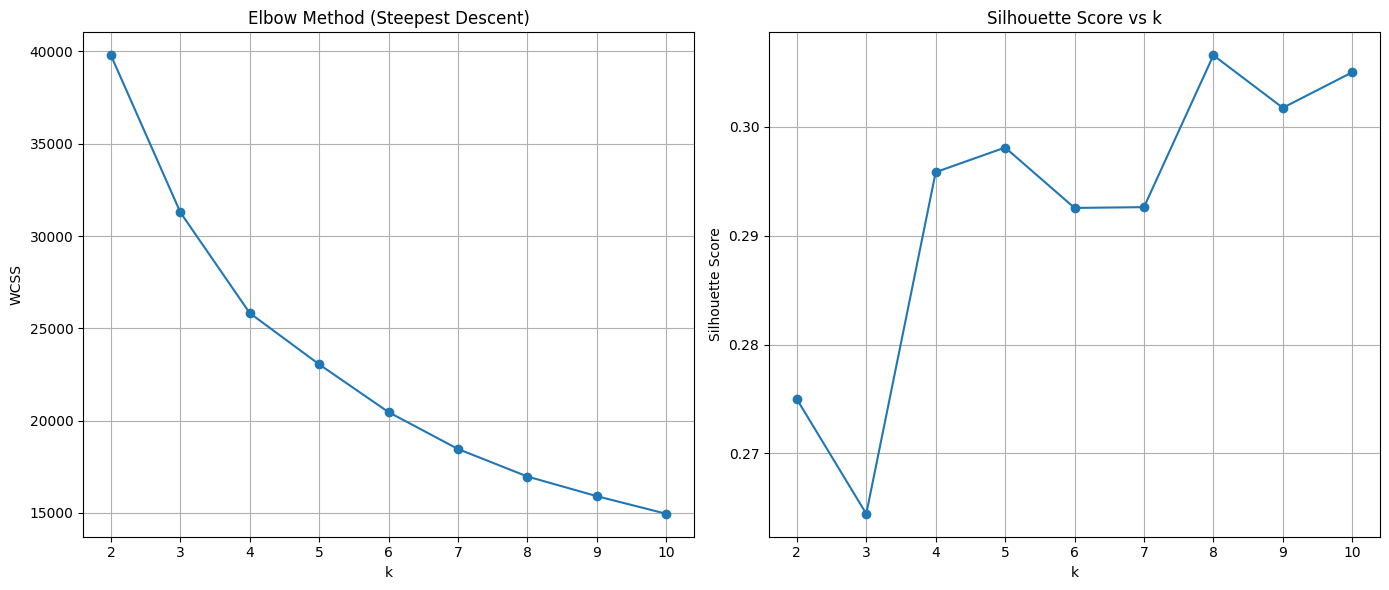

In [ ]:
k_range = range(2, 11)
wcss_steepest = []
silhouette_scores = []

X_scaled = df_yeojohnson[cols].values

print("Menghitung WCSS & Silhouette Score...")

for k in tqdm(k_range):
    centroids, labels, loss_history, wcss_sd = kmeans_steepest_descent(
        X_scaled,
        k=k,
        alpha=0.01,
        n_init=10
    )

    wcss_steepest.append(wcss_sd)

    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

    print(f"k={k} | WCS={wcss_sd:.2f} | Silhouette={score:.4f}")

# Plot
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss_steepest, 'o-')
plt.title("Elbow Method (Steepest Descent)")
plt.xlabel("k")
plt.ylabel("WCSS")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'o-')
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()


### Analisis Pemilihan Cluster Optimal

Evaluasi jumlah cluster dilakukan dengan dua metrik: **WCSS (Elbow)** dan **Silhouette Score**.

---

## Ringkasan Hasil

| k | WCSS | Silhouette |
|---|-------------|-----------|
| 2 | 39,795.08 | 0.2750 |
| 3 | 31,283.62 | 0.2645 |
| **4** | **25,822.96** | **0.2958** |
| 5 | 23,044.18 | 0.2981 |
| 6 | 20,454.50 | 0.2925 |
| 7 | 18,456.09 | 0.2926 |
| **8** | **16,966.67** | **0.3066** |
| 9 | 15,901.57 | 0.3017 |
| 10 | 14,946.77 | 0.3050 |

---

## Interpretasi

- **Elbow Method**: Penurunan WCSS melandai secara signifikan setelah **k=4** (dari selisih ~5.400 menjadi ~2.800), sehingga k=4 menjadi titik siku (*elbow*) yang jelas.
- **Silhouette Score**: Nilai *Silhouette* mengalami fluktuasi dan mencapai puncaknya pada **k=8** (0.3066), namun perbedaannya dengan k=4 (0.2958) tidak terlalu drastis.

---

## Kesimpulan

Dipilih **k=4** karena:
- Merupakan titik siku (*elbow*) yang paling signifikan pada kurva WCSS.
- Memberikan nilai *Silhouette Score* yang kompetitif (0.2958) dibandingkan k=3 atau k=2.
- Menghasilkan jumlah segmen yang cukup ringkas untuk strategi bisnis dibandingkan k=8.

Meskipun Silhouette tertinggi ada pada **k=8**, **k=4 adalah pilihan paling praktis dan mudah dijelaskan** untuk segmentasi pengguna ini.

## Clustering

In [ ]:
# -------------------------------
# 6. Final Clustering dengan k optimal
# -------------------------------
k_final = 4  # pakai k=4 sesuai hasil analisis

# Jalankan algoritma
centroids, labels, loss_history, final_wcss = kmeans_steepest_descent(
    X_scaled,
    k=k_final,
    alpha=0.01,
    n_init=10
)

# Masukkan label ke dataframe
df['cluster'] = labels

# Tampilkan Output (Hanya WCSS)
print("\n=== HASIL CLUSTERING (k =", k_final, ") ===")
print(f"Final WCSS: {final_wcss:.2f}")

# Export hasil
df.to_csv('clustered_daily_activity.csv', index=False)
print("\nHasil disimpan ke 'clustered_daily_activity.csv'")



=== HASIL CLUSTERING (k = 4 ) ===
Final WCSS: 25822.96

Hasil disimpan ke 'clustered_daily_activity.csv'


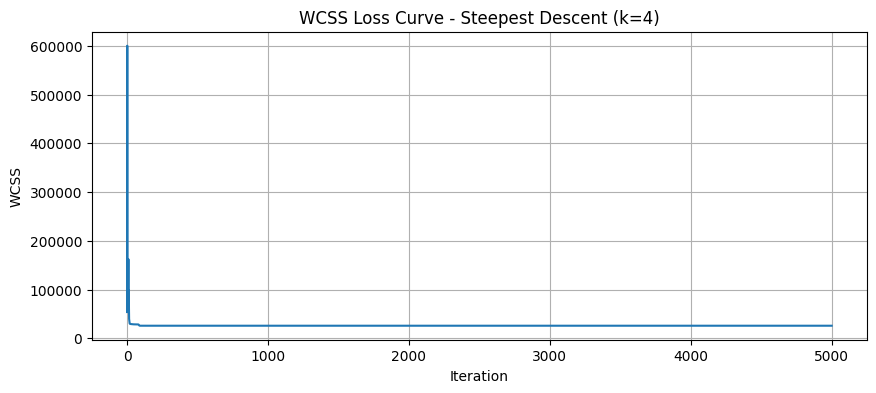

In [ ]:
# Plot loss curve
plt.figure(figsize=(10,4))
plt.plot(loss_history)
plt.title(f'WCSS Loss Curve - Steepest Descent (k={k_final})')
plt.xlabel('Iteration')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

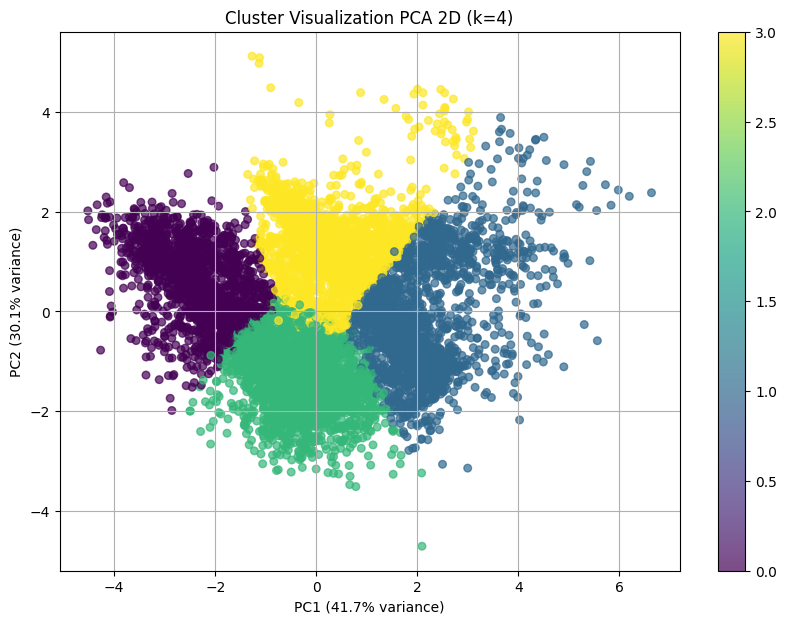

In [ ]:
# PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,7))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', s=30, alpha=0.7)
plt.title(f'Cluster Visualization PCA 2D (k={k_final})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter)
plt.grid(True)
plt.show()

## Analisis dan Observasi Cluster

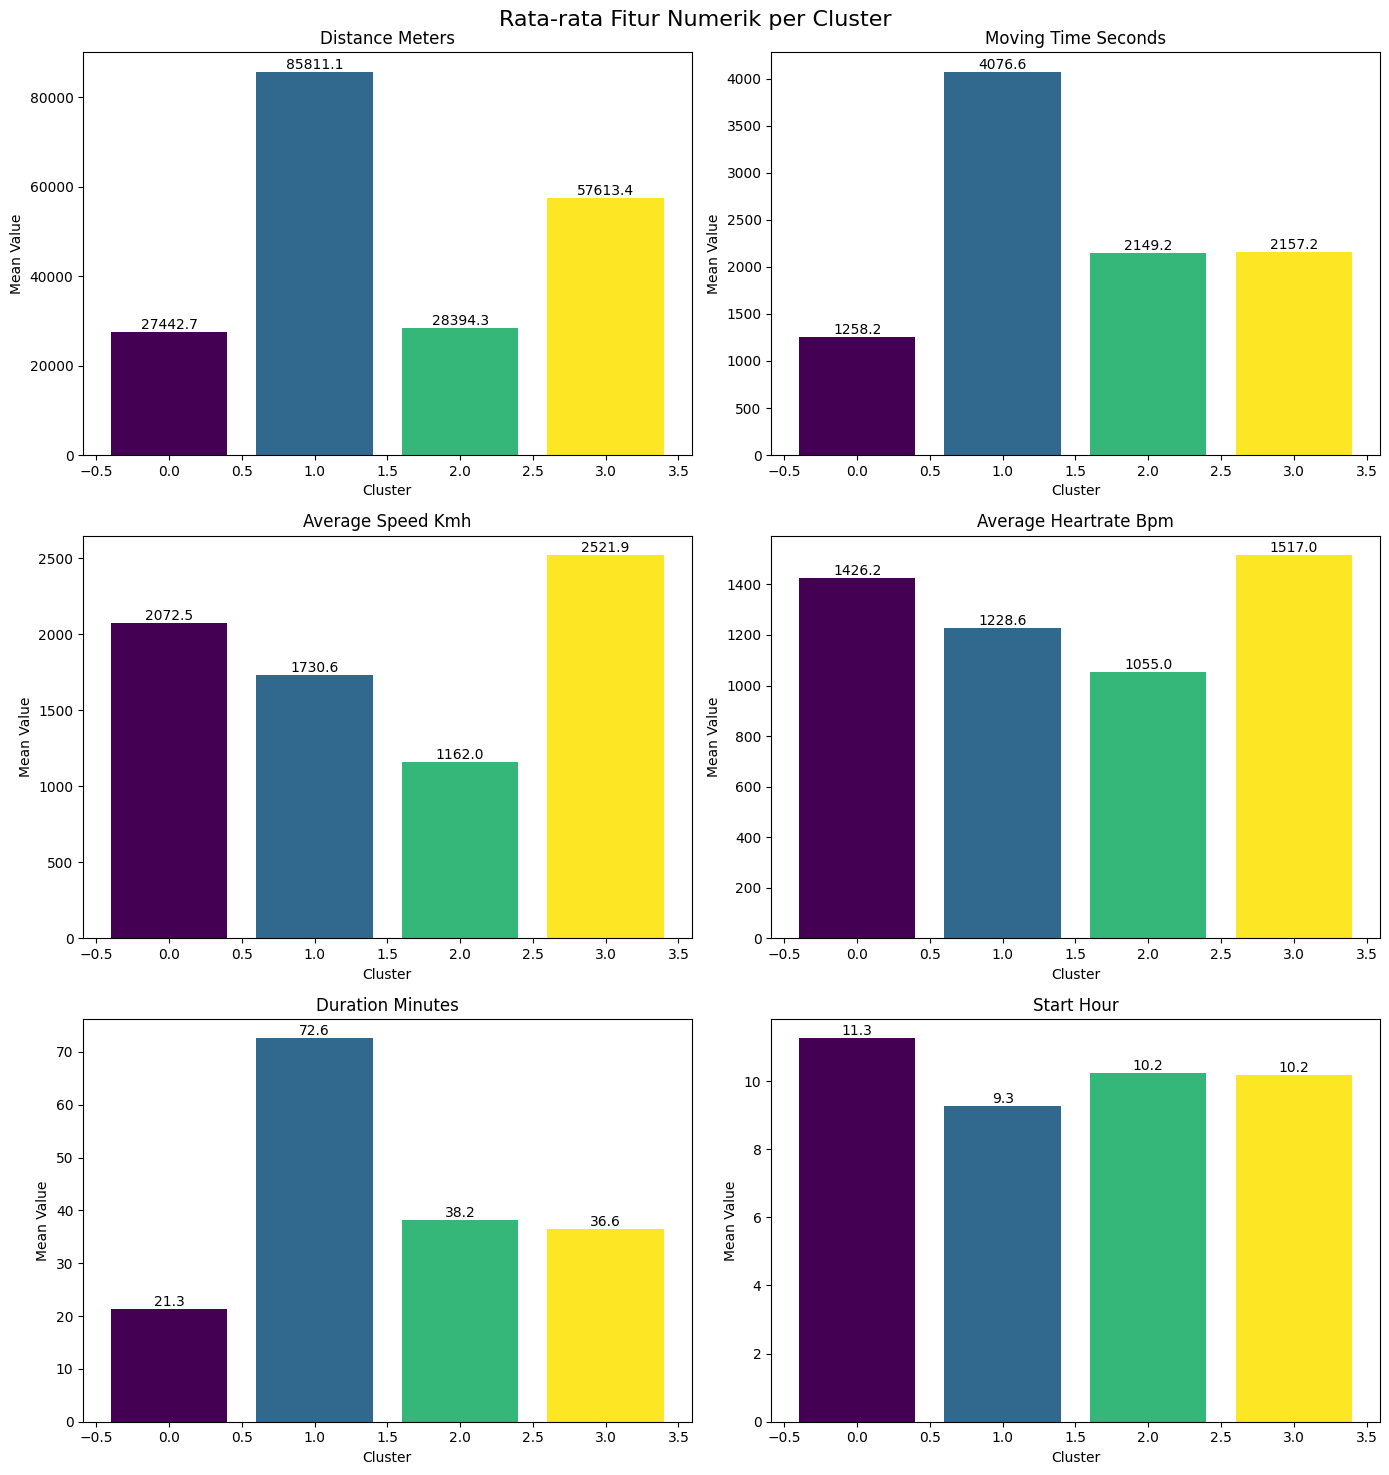

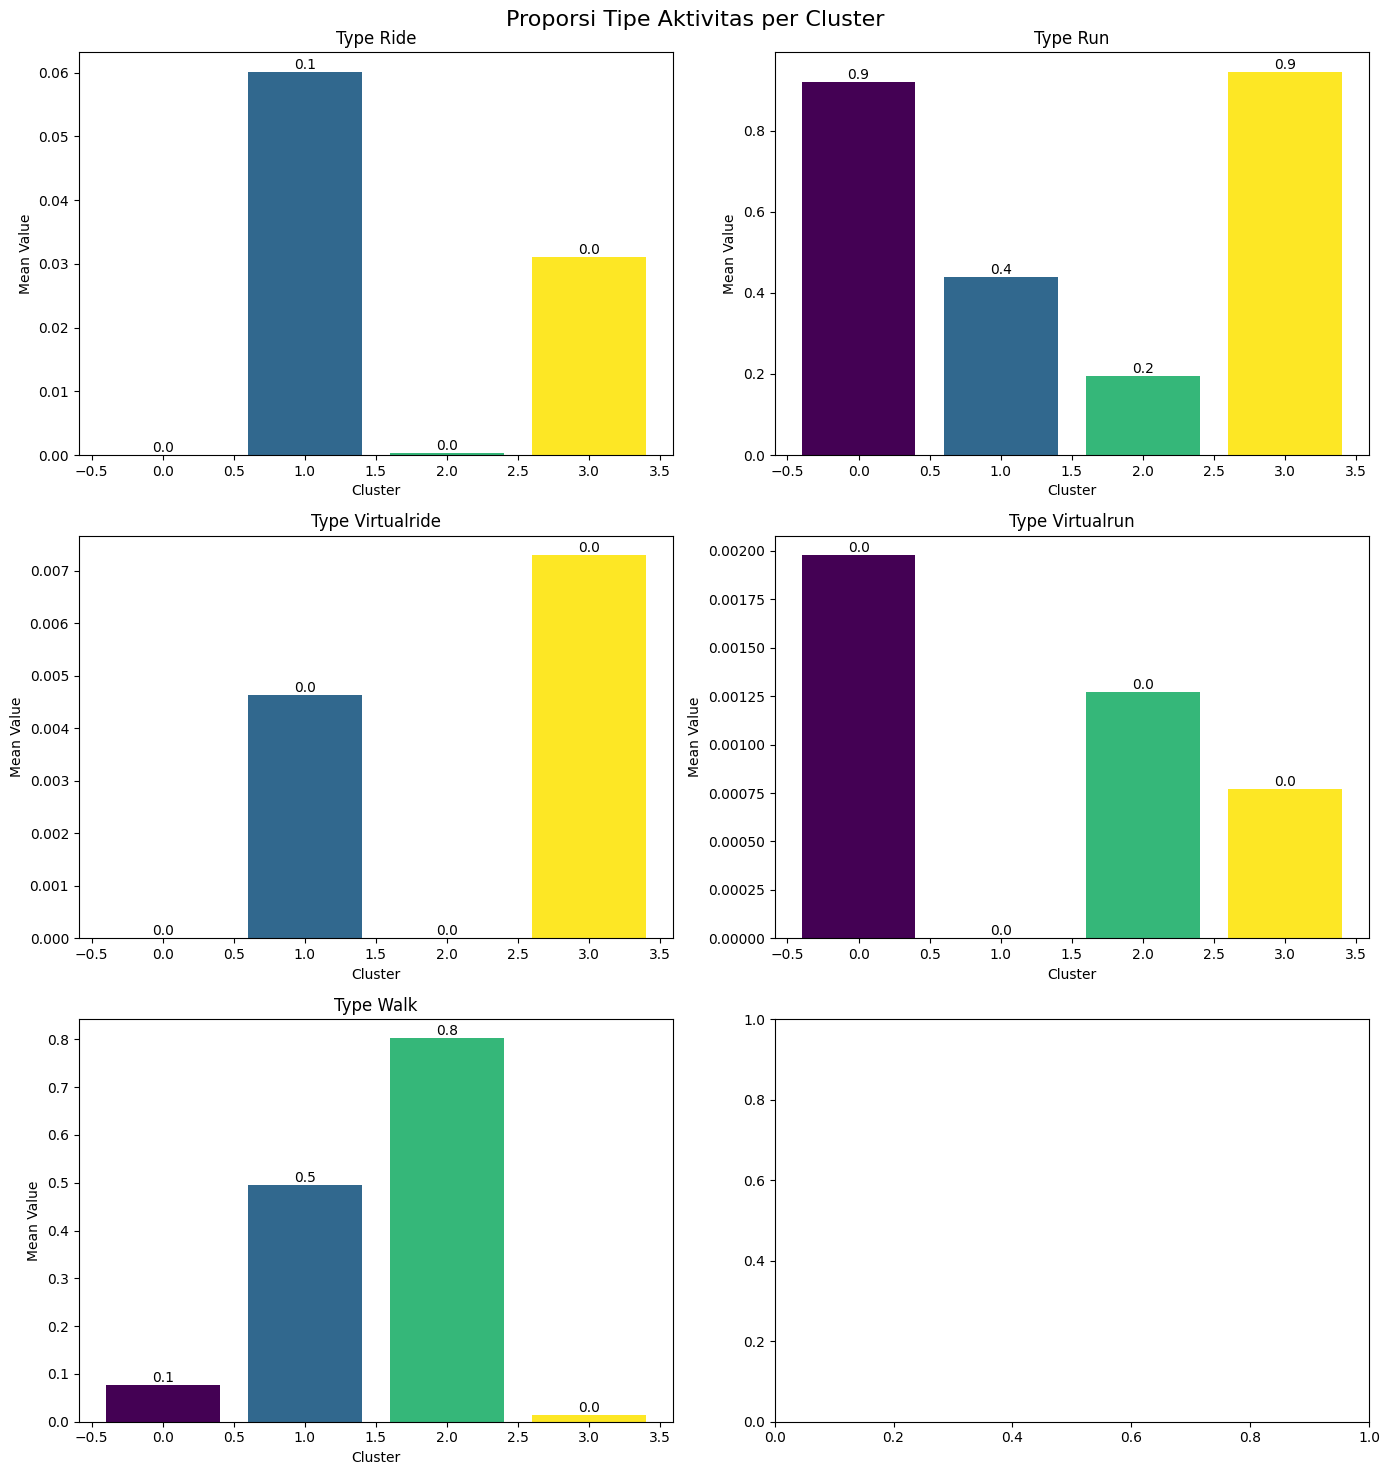

In [ ]:
# -------------------------------
# 7. Analisis Cluster (Bar Plot + Radar Chart)
# -------------------------------
import math # Added to resolve NameError

cluster_means = df.groupby('cluster').mean(numeric_only=True)

key_features = ['distance_meters', 'moving_time_seconds', 'average_speed_kmh',
                'average_heartrate_bpm', 'duration_minutes', 'start_hour']
activity_cols = [col for col in df.columns if col.startswith('type_')]

# Bar plots (Improvement: Pakai matplotlib murni, tanpa seaborn)
def plot_cluster_features(features, title):
    n_rows = math.ceil(len(features)/2)
    fig, axes = plt.subplots(n_rows, 2, figsize=(14, 5*n_rows))
    axes = axes.flatten()

    for i, feat in enumerate(features):
        axes[i].bar(cluster_means.index, cluster_means[feat], color=plt.cm.viridis(np.linspace(0,1,len(cluster_means))))
        axes[i].set_title(feat.replace('_', ' ').title())
        for j, v in enumerate(cluster_means[feat]):
            axes[i].text(j, v, f'{v:.1f}', ha='center', va='bottom')
        axes[i].set_xlabel('Cluster')
        axes[i].set_ylabel('Mean Value')

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_cluster_features(key_features, 'Rata-rata Fitur Numerik per Cluster')
plot_cluster_features(activity_cols, 'Proporsi Tipe Aktivitas per Cluster')

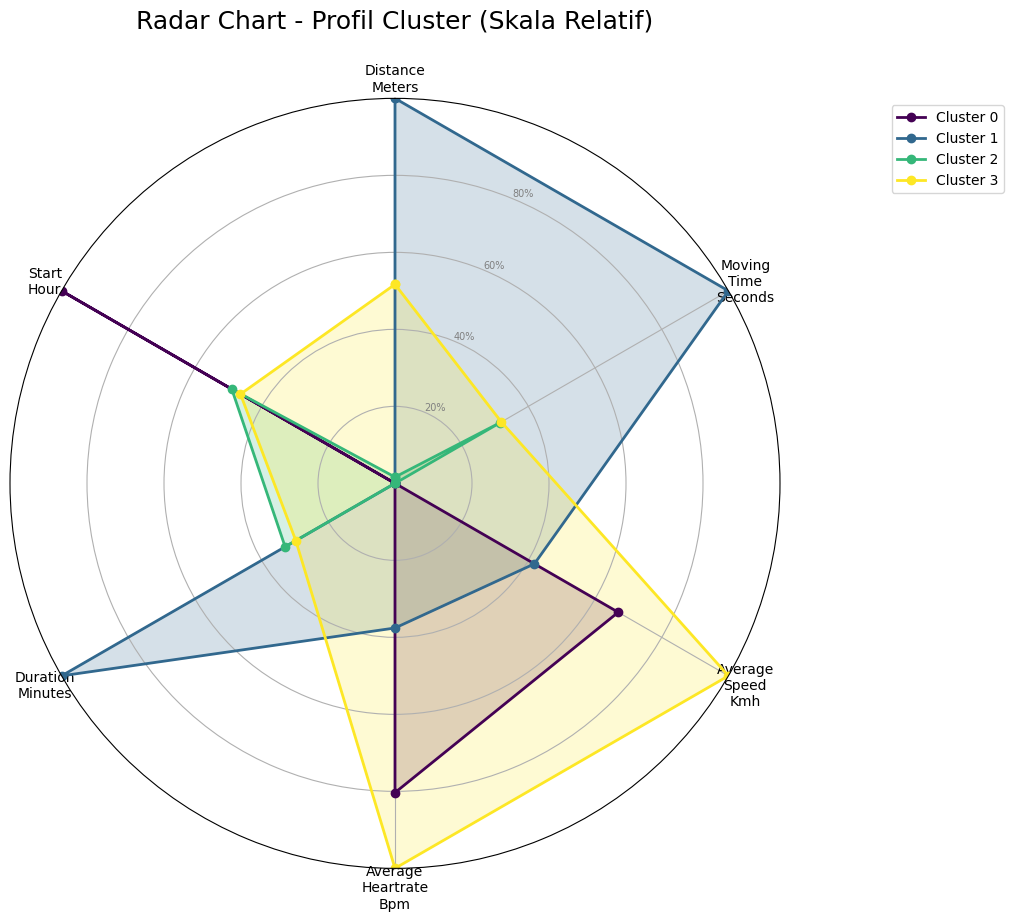

In [ ]:
# Radar Chart (Improvement: Tambah grid dan labels lebih jelas)
scaler_radar = MinMaxScaler()
radar_data = cluster_means[key_features]
radar_scaled = pd.DataFrame(scaler_radar.fit_transform(radar_data), columns=key_features, index=radar_data.index)

categories = list(radar_scaled.columns)
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(polar=True))
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], [c.replace('_', '\n').title() for c in categories])
plt.yticks([0.2, 0.4, 0.6, 0.8], ["20%", "40%", "60%", "80%"], color="grey", size=7)  # Improvement: % labels
plt.ylim(0,1)
ax.grid(True)  # Improvement: Tambah grid

colors = plt.cm.viridis(np.linspace(0,1,len(radar_scaled)))
for i, (idx, row) in enumerate(radar_scaled.iterrows()):
    values = row.tolist() + row.tolist()[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {idx}', color=colors[i])
    ax.fill(angles, values, color=colors[i], alpha=0.2)

plt.title('Radar Chart - Profil Cluster (Skala Relatif)', size=18, y=1.08)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.show()

In [ ]:
# -------------------------------
# 8. Interpretasi (bisa kamu sesuaikan)
# -------------------------------
print("\n=== INTERPRETASI CLUSTER (k =", k_final, ") ===")
print(df['cluster'].value_counts().sort_index())


=== INTERPRETASI CLUSTER (k = 4 ) ===
cluster
0    1516
1    1944
2    3148
3    2600
Name: count, dtype: int64


### Profil Masing-masing Cluster (Revisi Berdasarkan Data Grafik)

#### **Cluster 0 (Ungu - Short Distance Fast Run)**
* **Karakteristik Utama:**
    * **Tipe Aktivitas:** Sangat didominasi oleh **Running (Lari)** dengan proporsi mendekati 90%.
    * **Kecepatan & Detak Jantung:** Memiliki rata-rata kecepatan tinggi (sekitar 2.072 unit) dan detak jantung yang cukup tinggi (sekitar 1.426 bpm), menempati urutan kedua tertinggi setelah Cluster 3.
    * **Jarak & Waktu:** Jarak tempuh tergolong pendek (sekitar 27.442 m) dengan durasi yang relatif singkat.
* **Interpretasi:** Cluster ini merepresentasikan aktivitas **Lari Cepat Jarak Pendek**. Pengguna melakukan sesi lari yang intens namun dengan rute atau durasi yang tidak terlalu panjang, kemungkinan merupakan sesi latihan rutin harian atau *morning run*.

#### **Cluster 1 (Biru - Endurance / Long Distance Mixed)**
* **Karakteristik Utama:**
    * **Jarak & Waktu:** Ini adalah cluster dengan **jarak tempuh terjauh** (mencapai rata-rata 85.811 m) dan durasi aktivitas paling lama (sekitar 4.076 detik *moving time*).
    * **Tipe Aktivitas:** Campuran variatif. Terdapat proporsi aktivitas *Ride* (Sepeda) yang paling terlihat dibanding cluster lain, dikombinasikan dengan jalan kaki dan lari.
    * **Kecepatan:** Kecepatan rata-rata menengah (sekitar 1.730 unit).
* **Interpretasi:** Cluster ini merepresentasikan aktivitas **Ketahanan Jarak Jauh (Endurance)**. Mengingat jaraknya yang sangat jauh dan adanya campuran aktivitas sepeda, ini kemungkinan besar adalah sesi olahraga durasi panjang seperti bersepeda jarak jauh, *hiking*, atau *long run* di akhir pekan.

#### **Cluster 2 (Hijau - Casual Walking)**
* **Karakteristik Utama:**
    * **Tipe Aktivitas:** Hampir murni **Walking (Jalan Kaki)** dengan proporsi di atas 80%.
    * **Kecepatan & Detak Jantung:** Merupakan cluster dengan intensitas paling ringan. Memiliki rata-rata kecepatan **terendah** (1.162 unit) dan detak jantung **terendah** (1.055 bpm).
    * **Jarak:** Jarak tempuh relatif pendek (sekitar 28.394 m), mirip dengan Cluster 0.
* **Interpretasi:** Cluster ini merepresentasikan aktivitas **Jalan Santai (Casual Walking)**. Berbeda dengan deskripsi teks lama yang menyebutnya "Interval Training", data grafik jelas menunjukkan ini adalah aktivitas intensitas rendah, kemungkinan besar jalan kaki santai atau aktivitas komuter ringan.

#### **Cluster 3 (Kuning - High Performance Running)**
* **Karakteristik Utama:**
    * **Kecepatan & Detak Jantung:** Cluster dengan performa puncak. Memiliki rata-rata kecepatan **tertinggi** (2.521 unit) dan detak jantung **tertinggi** (1.517 bpm).
    * **Tipe Aktivitas:** Sangat dominan **Running (Lari)** di atas 90%.
    * **Jarak:** Jarak tempuh cukup jauh (sekitar 57.613 m), jauh lebih tinggi daripada Cluster 0 tetapi di bawah Cluster 1.
* **Interpretasi:** Cluster ini merepresentasikan **Pelari Performa Tinggi (High Performance Runners)**. Pengguna di kelompok ini berlari dengan jarak yang cukup jauh (menengah ke atas) dengan kecepatan dan usaha (*effort*) maksimal.

## ⛳ Terimakasih